#Done By:
* Rasha Jabbour
* Ramez Nafeh
* Jasmine El Afyouni


# 1) Pre-processing

## Preliminary Steps
Import libraries

In [1]:
# The libraries we will use are imported here, in case of runtime problems
import os, shutil  #  file management
import sys 
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm # debugging (progress bars)
import matplotlib.pyplot as plt
import sklearn
import copy

# typing
from typing import List, Callable, Dict

In [2]:
dataset_name = "dependency_treebank"

If it is necessary, clean all the data that are in the DATASETS directory and wipe out all the subdirectories.


In [3]:
folder = os.getcwd()

print("Current work directory: " + str(folder))

dataset_folder = os.path.join(os.getcwd(), "Datasets")
print(dataset_folder)
# create Datasets dir if it doesnt exist
if not os.path.exists(dataset_folder): 
    os.makedirs(dataset_folder)

for filename in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

print("Cleaned")

Current work directory: C:\Users\rasha
C:\Users\rasha\Datasets
Cleaned


## Dataset Download
Dowload & extract the treebank


In [4]:
import urllib.request  #  download files
import tarfile  #  unzip files
from zipfile import ZipFile

dataset_folder = os.path.join(os.getcwd(), "Datasets", "Original")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")

with ZipFile(dataset_path, 'r') as zip:
    zip.extractall(dataset_folder)

print("Successful extraction")

Successful download
Successful extraction


## Create the dataframe
Now the dataset is loaded into a dataframe to be more accessible.
During the creation some data will be printed as an example.

row format: file_id, text, tags, split


In [5]:
debug = True

dataframe_rows = []

folder = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name)
filenames = sorted(os.listdir(folder))
split = " "
for i in range(199):
    if i < 99:
        split = "train"
    elif i > 99 and i < 149:
        split = "validation"
    elif i > 149 and i < 199:
        split = "test"

    file_path = os.path.join(folder, filenames[i])
    try:
        if os.path.isfile(file_path):
            # open the file
            with open(file_path, mode='r', encoding='utf-8') as text_file:
                # read it
                text = text_file.read()
                
                words = []
                tags = []

                # split document between words and tags
                lines = text.splitlines()
                for line in lines:
                    l = line.split("\t")
                    if l[0] == '': continue #   skip this annoying char
                    words.append(l[0].lower())
                    tags.append(l[1])

                #create single dataframe row
                dataframe_row = { 
                    "file_id": filenames[i],
                    "text": words ,
                    "tags": tags ,
                    "split": split
                }    
                dataframe_rows.append(dataframe_row)

    except Exception as e:
        print('Failed to process %s. Reason: %s' % (file_path, e))
        sys.exit(0)

folder = os.path.join(os.getcwd(), "Datasets", "Dataframes", dataset_name)
if not os.path.exists(folder):
    os.makedirs(folder)

# transform the list of rows in a proper dataframe
df = pd.DataFrame(dataframe_rows)
df = df[["file_id",
            "text",
            "tags",
            "split"]]
dataframe_path = os.path.join(folder, dataset_name + ".pkl")
df.to_pickle(dataframe_path)
df

,file_id,text,tags,split
0,wsj_0001.dp,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",train
1,wsj_0002.dp,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",train
2,wsj_0003.dp,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",train
3,wsj_0004.dp,"[yields, on, money-market, mutual, funds, cont...","[NNS, IN, JJ, JJ, NNS, VBD, TO, VB, ,, IN, NNS...",train
4,wsj_0005.dp,"[j.p., bolduc, ,, vice, chairman, of, w.r., gr...","[NNP, NNP, ,, NN, NN, IN, NNP, NNP, CC, NNP, ,...",train
...,...,...,...,...
194,wsj_0195.dp,"[john, f., barrett, ,, 40, ,, formerly, execut...","[NNP, NNP, NNP, ,, CD, ,, RB, JJ, NN, NN, CC, ...",test
195,wsj_0196.dp,"[leon, j., level, ,, vice, president, and, chi...","[NNP, NNP, NNP, ,, NN, NN, CC, NN, JJ, NN, IN,...",test
196,wsj_0197.dp,"[david, a., diloreto, ,, president, of, metal,...","[NNP, NNP, NNP, ,, NN, IN, NN, NN, NN, ,, VBD,...",test
197,wsj_0198.dp,"[two, leading, constitutional-law, experts, sa...","[CD, VBG, NN, NNS, VBD, NNP, NNP, VBZ, RB, VB,...",test


##PRE-PROCESSING FUNCTIONS DEFINITON

Let's define the functions that will be used for the pre-processing

### Load pre-trained model

In [6]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = ""

    # Find the correct embedding model name
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones:\
         word2vec, glove, fasttext")

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

c:\users\rasha\appdata\local\programs\python\python38\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


###Check out of vocabulary (OOV) words

In [7]:
# Function definition

def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """

    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

###Build embedding matrix and Handle OOV words

In [8]:
# Function definition
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           oov_terms,
                           vocab_size=50) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    

    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError): #if OOV
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

###Create the Tokenizer class

In [9]:
class KerasTokenizer(object):
    """
    A simple high-level wrapper for the Keras tokenizer.
    """

    def __init__(self, tokenizer_args=None):
        self.vocab = None
        tokenizer_args = {} if tokenizer_args is None else tokenizer_args
        assert isinstance(tokenizer_args, dict) or isinstance(tokenizer_args, collections.OrderedDict)

        self.tokenizer_args = tokenizer_args
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(**self.tokenizer_args)

    def build_vocab(self, data, **kwargs):
        print('Fitting tokenizer...')
        self.tokenizer.fit_on_texts(data)
        print('Fit completed!')
        self.vocab = self.tokenizer.word_index

    def get_info(self):
        return {
            'vocab_size': len(self.vocab) + 1,
        }
    
    def tokenize(self, text):
        return text

    def convert_tokens_to_ids(self, tokens):
        if type(tokens) == str:
            return self.tokenizer.texts_to_sequences([tokens])[0]
        else:
            return self.tokenizer.texts_to_sequences(tokens)

    def convert_ids_to_tokens(self, ids):
        return self.tokenizer.sequences_to_texts(ids)

### Data Splitting

In [10]:
# Global splits variables
x_train, y_train, x_val, y_val, x_test, y_test = 0,0,0,0,0,0

In [11]:
def split_data(n1,n2): 
    """
    splits data into train, validation and test sets

    :param n1: size of train split
    :param n2: size of validation split
    
    """
    global x_train, y_train, x_val, y_val, x_test, y_test
    TRAIN_SPLIT = n1
    VAL_SPLIT = n2

    train_data = df[df['split'] == 'train']
    validation_data = df[df['split'] == 'validation']
    test_data = df[df['split'] == 'test']

    x_train = train_data['text'].values[:TRAIN_SPLIT]
    y_train = train_data['tags'].values[:TRAIN_SPLIT]

    x_val = validation_data['text'].values[:VAL_SPLIT]
    y_val = validation_data['tags'].values[:VAL_SPLIT]

    x_test = test_data['text'].values
    y_test = test_data['tags'].values

    print('Dataset splits statistics: ')
    print('Train data: ', x_train.shape)
    print('Validation data: ', x_val.shape)
    print('Test data: ', x_test.shape)

###Buid vocabulary and embedding matrix

In [12]:
def init_embedding_matrix(embedding_dimension=200):
    """
    declares and initializes embedding matrix 

    :param embedding_dimension: embedding dimension
    
    """

    global x_train,x_val,x_test
    a=np.concatenate([x_train,
                      x_val
                     , x_test
                      ])
    total=[]
    for l in a:
        total = np.concatenate([total,l])
    unique_words=set(total)
    
    global embedding_matrix
    embedding_matrix = np.zeros((len(unique_words)+2,
                                 embedding_dimension),
                                 dtype=np.float32) 

In this rather long function below, we initalize a **tokenizer** for all the words of the dataset and similarily a **tags_tokenizer** for all the tags. We also call init_embedding_matrix() to initialize the embedding matrix that will store all of the embeddings. Then for each of the train, validation and test splits we:

1.   Build the vocab for words
2.   Build the vocab for tags
3.   Add the embeddings to the single cumulative embedding matrix

**Note**: we assigned random embeddings for OOV terms thus they are naturally independent from the data, however we still computed them independently for each split in build_embedding_matrix() in case an improved method of OOV handling is adopted.

In [110]:
def build_vocabulary(embedding_dimension):
    """
    Builds the vocabulary and populates the embedding matrix

    :param embedding_dimension: dimension of embedding matrix 
    
    :return
        - word tokenizer and tags tokenizer
    """
    global x_train, y_train, x_val, y_val, x_test, y_test

    tokenizer_args = {
        'filters': '', # dont filter out punctuation
        'oov_token': 1 # The vocabulary id for unknown terms during text conversion
    }

    # word tokenizer
    tokenizer = KerasTokenizer(tokenizer_args=tokenizer_args)
    
    # tags tokenizer
    tags_tokenizer = KerasTokenizer()

    init_embedding_matrix(embedding_dimension)

    ''' 
    In the next part, 

    V1:     train vocabulary
    V2:     validation vocabulary
    V3:     test vocabulary
    V12:    V1+V2
    V123:   V1+V2+V3

    since build_vocab() will add the words to the same dictionary, V1 and V1+V2 
    are saved as intermediary values needed to compute the vocabulary and 
    embeddings of the next split independently from the other splits
    '''

    # TRAIN
    tokenizer.build_vocab(x_train) # build train set vocab V1
    tags_tokenizer.build_vocab(y_train) # build vocab for train tags

    # save V1 in order to later get V2 = V12 - V1
    V1 = tokenizer.vocab
    
    # compute embeddings for train set
    OOV1 = check_OOV_terms(embedding_model, tokenizer.vocab.keys())
    build_embedding_matrix(embedding_model,
                            word_to_idx=V1,
                            embedding_dimension=embedding_dimension,
                            oov_terms=OOV1)
    

    # VAL
    tokenizer.build_vocab(x_val) # build val set vocab V2
    tags_tokenizer.build_vocab(y_val) # build vocab for val tags

    # compute V2 = V12 - V1. We subtract V1 from the current vocab of 
    # the tokenizer
    V2 = {k:v for k,v in tokenizer.vocab.items() if k not in V1} 

    # save V1+V2 in order to later get V3 = V123 - V12
    V12 = tokenizer.vocab

    # compute embeddings for val set
    OOV2 = check_OOV_terms(embedding_model, tokenizer.vocab.keys())
    build_embedding_matrix(embedding_model,
                            word_to_idx=V2,
                            embedding_dimension=embedding_dimension,
                            oov_terms=OOV2)
    

    # TEST
    tokenizer.build_vocab(x_test) # build test set vocab V3
    tags_tokenizer.build_vocab(y_test) # build vocab for test tags

    # V3 = V123 - V12. We subtract V12 from the current vocab of 
    # the tokenizer
    V3 = {k:v for k,v in tokenizer.vocab.items() if k not in V12} 

    # compute embeddings for test set
    OOV3 = check_OOV_terms(embedding_model, tokenizer.vocab.keys())
    build_embedding_matrix(embedding_model,
                            word_to_idx=V3,
                            embedding_dimension=embedding_dimension,
                            oov_terms = OOV3)


    tokenizer_info = tokenizer.get_info()
    tags_tokenizer_info = tags_tokenizer.get_info()
    print('\nWord Tokenizer info: ', tokenizer_info)
    print('\nTags Tokenizer info: ', tags_tokenizer_info)

    return tokenizer, tags_tokenizer

###Convert

In [14]:
def convert_text(texts, tokenizer, is_training=False, max_seq_length=None):
    """
    Converts input text sequences using a given tokenizer

    :param texts: either a list or numpy ndarray of strings
    :tokenizer: an instantiated tokenizer
    :is_training: whether input texts are from the training split or not
    :max_seq_length: the max token sequence previously computed with
    training texts.

    :return
        text_ids: a nested list on token indices
        max_seq_length: the max token sequence previously computed with
        training texts.
    """

    text_ids = tokenizer.convert_tokens_to_ids(texts)

    # Padding
    if is_training:
        max_seq_length = int(np.quantile([len(seq) for seq in text_ids], 0.99))
    else:
        assert max_seq_length is not None

    text_ids = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids]
    text_ids = np.array([seq[:max_seq_length] for seq in text_ids])

    if is_training:
        return text_ids, max_seq_length
    else:
        return text_ids

In [111]:
def convert(tokenizer, tags_tokenizer):
    """
    Converts input text sequences using a given tokenizer

    :tokenizer: an instantiated tokenizer for words
    :tags_tokenizer: an instantiated tokenizer for words

    :return
        max_seq_length: the max token sequence previously computed with
        training texts.
    """
    global x_train, y_train, x_val, y_val, x_test, y_test

    # Train
    x_train, max_seq_length = convert_text(x_train, tokenizer, True)
    y_train = convert_text(y_train, tags_tokenizer, False, max_seq_length)

    # Val
    x_val = convert_text(x_val, tokenizer, False, max_seq_length)
    y_val = convert_text(y_val, tags_tokenizer, False, max_seq_length)

    # Test
    x_test = convert_text(x_test, tokenizer, False, max_seq_length)
    y_test = convert_text(y_test, tags_tokenizer, False, max_seq_length)
    
    print("Max token sequence: {}".format(max_seq_length))

    print('X train shape: ', x_train.shape)
    print('Y train shape: ', y_train.shape)

    print('X val shape: ', x_val.shape)
    print('Y val shape: ', y_val.shape)

    print('X test shape: ', x_test.shape)
    print('Y test shape: ', y_test.shape)

    return max_seq_length

##**RUN PRE-PROCESSING FUNCTIONS**

In this section we call all of the pre-processing functions to ready our data to be given to the models.

In [16]:
# pre-processing params

#num of documents used
TRAIN_SIZE = 100
VAL_SIZE = 50
# Glove -> 50, 100, 200, 300
embedding_model_type = "glove"
embedding_dimension = 200

In [17]:
# load embedding model
embedding_model = load_embedding_model(embedding_model_type, embedding_dimension)

In [18]:
# split data into train val and test
split_data(TRAIN_SIZE, VAL_SIZE)

# get length of each sample before padding to truncate them later
y_test_lens = [len(sample) for sample in y_test] 

# build the vocab for text and tags
tokenizer, tags_tokenizer = build_vocabulary(embedding_dimension)

# convert sequences to integers and pad them
max_seq_length = convert(tokenizer, tags_tokenizer)

tags=list(tags_tokenizer.vocab.keys())
tag_ids=list(tags_tokenizer.vocab.values())

Dataset splits statistics: 
Train data:  (100,)
Validation data:  (50,)
Test data:  (49,)
Fitting tokenizer...
Fit completed!
Fitting tokenizer...
Fit completed!


100%|███████████████████████████████████████████████████████████████████████████| 7405/7405 [00:00<00:00, 88884.24it/s]


Fitting tokenizer...
Fit completed!
Fitting tokenizer...
Fit completed!


100%|███████████████████████████████████████████████████████████████████████████| 2497/2497 [00:00<00:00, 55279.09it/s]


Fitting tokenizer...
Fit completed!
Fitting tokenizer...
Fit completed!


100%|███████████████████████████████████████████████████████████████████████████| 1046/1046 [00:00<00:00, 45597.84it/s]


Word Tokenizer info:  {'vocab_size': 10949}

Tags Tokenizer info:  {'vocab_size': 46}


Max token sequence: 1897
X train shape:  (100, 1897)
Y train shape:  (100, 1897)
X val shape:  (50, 1897)
Y val shape:  (50, 1897)
X test shape:  (49, 1897)
Y test shape:  (49, 1897)


# 2) Models

Import necessary libraries

In [19]:
from sklearn.metrics import f1_score, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout, Masking, Embedding, Bidirectional, TimeDistributed

In [20]:
vocab_size = len(tokenizer.vocab)+1
num_classes = len(tags_tokenizer.vocab)+1

##Model functions definition

In [21]:
def show_history(history: keras.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """

    history_data = history.history
    print("Displaying the following history keys: ", history_data.keys())

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if 'val_{}'.format(key) in history_data:
                ax.plot(history_data['val_{}'.format(key)])
            else:
                print("Couldn't find validation values for metric: ", key)

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')

    plt.show()


def train_model(model: keras.Model,
                x_train: np.ndarray,
                y_train: np.ndarray,
                x_val: np.ndarray,
                y_val: np.ndarray,
                training_info: Dict):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param x_train: training data in np.ndarray format
    :param y_train: training labels in np.ndarray format
    :param x_val: validation data in np.ndarray format
    :param y_val: validation labels in np.ndarray format
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print("Start training! \nParameters: {}\nTrain size: {}\nVal size: {}".format(training_info,TRAIN_SIZE,VAL_SIZE))
    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed! Showing history...")

    show_history(history)

    return model


def predict_data(model: keras.Model,
                 x: np.ndarray,
                 prediction_info: Dict) -> np.ndarray:
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """

    print('Starting prediction: \n{}'.format(prediction_info))
    print('Predicting on {} samples'.format(x.shape[0]))

    predictions = model.predict(x, **prediction_info)
    return predictions


def evaluate_predictions(predictions: np.ndarray,
                         y: np.ndarray,
                         metrics: List[Callable],
                         metric_names: List[str]):
    """
    Evaluates given model predictions on a list of metric functions

    :param predictions: model predictions in np.ndarray format
    :param y: ground-truth labels in np.ndarray format
    :param metrics: list of metric functions
    :param metric_names: list of metric names

    :return
        metric_info: dictionary containing metric values for each input metric
    """

    assert len(metrics) == len(metric_names)

    print("Evaluating predictions! Total samples: ", y.shape[0])

    metric_info = {}

    for metric, metric_name in zip(metrics, metric_names):
        metric_value = metric(y_pred=predictions, y_true=y)
        metric_info[metric_name] = metric_value

    return metric_info

## Baseline model

###Compile

In [24]:
baseline = Sequential()

# Embedding layer
baseline.add(Embedding(input_dim = vocab_size,
              input_length = max_seq_length,
              output_dim=embedding_dimension,
              weights = embedding_matrix if embedding_matrix is None else [embedding_matrix],
              trainable=False,
              mask_zero=True))

# Bidirectional layer
baseline.add(Bidirectional(LSTM(64, return_sequences=True 
               ,dropout=0.1
               )))               

baseline.add(TimeDistributed(Dense(num_classes,
            activation= 'softmax')))

# Compile the model
baseline.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
baseline.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1897, 200)         2189800   
                                                                 
 bidirectional_1 (Bidirectio  (None, 1897, 128)        135680    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 1897, 46)         5934      
 tributed)                                                       
                                                                 
Total params: 2,331,414
Trainable params: 141,614
Non-trainable params: 2,189,800
_________________________________________________________________


### Train

Start training! 
Parameters: {'verbose': 1, 'epochs': 1000, 'batch_size': 32, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x000001DCECED0E80>]}
Train size: 100
Val size: 50
Epoch 1/1000
4/4 [==============================] - 30s 3s/step - loss: 0.9192 - accuracy: 0.0482 - val_loss: 1.0497 - val_accuracy: 0.1394
Epoch 2/1000
4/4 [==============================] - 2s 630ms/step - loss: 0.8308 - accuracy: 0.1410 - val_loss: 0.9677 - val_accuracy: 0.1699
Epoch 3/1000
4/4 [==============================] - 2s 594ms/step - loss: 0.7746 - accuracy: 0.1657 - val_loss: 0.9158 - val_accuracy: 0.1770
Epoch 4/1000
4/4 [==============================] - 3s 705ms/step - loss: 0.7349 - accuracy: 0.1820 - val_loss: 0.8866 - val_accuracy: 0.2524
Epoch 5/1000
4/4 [==============================] - 3s 695ms/step - loss: 0.7134 - accuracy: 0.2588 - val_loss: 0.8670 - val_accuracy: 0.2767
Epoch 6/1000
4/4 [==============================] - 2s 645ms/step - loss: 0.6970 - accuracy: 0.2795 - val_lo

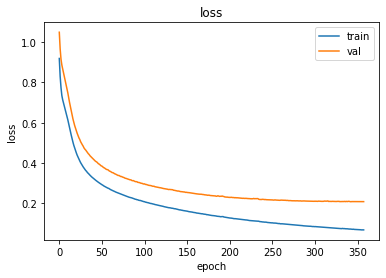

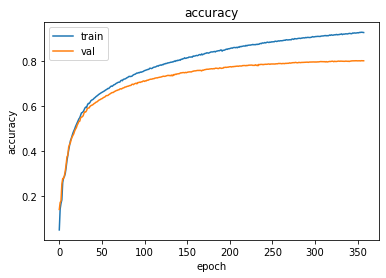

In [25]:
# Training

training_info = {
    'verbose': 1,
    'epochs': 1000,
    'batch_size': 32,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=15,
                                                restore_best_weights=True)]
}
baseline = train_model(model=baseline, x_train=x_train, y_train=y_train,
                    x_val=x_val, y_val=y_val, training_info=training_info)

##GRU Model

###Compile

In [26]:
GRU_model = Sequential()

# Embedding layer
GRU_model.add(Embedding(input_dim = vocab_size,
              input_length = max_seq_length,
              output_dim = embedding_dimension,
              weights = embedding_matrix if embedding_matrix is None else [embedding_matrix],
              trainable=False,
              mask_zero=True))

# GRU layer
GRU_model.add(GRU(64, return_sequences=True 
               ,dropout=0.1
               ))               

# Dense layer
GRU_model.add(TimeDistributed(Dense(num_classes,
            activation= 'softmax')))

# Compile the model
GRU_model.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
GRU_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1897, 200)         2189800   
                                                                 
 gru (GRU)                   (None, 1897, 64)          51072     
                                                                 
 time_distributed_2 (TimeDis  (None, 1897, 46)         2990      
 tributed)                                                       
                                                                 
Total params: 2,243,862
Trainable params: 54,062
Non-trainable params: 2,189,800
_________________________________________________________________


###Train 

Start training! 
Parameters: {'verbose': 1, 'epochs': 1000, 'batch_size': 32, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x000001DCE81B4FD0>]}
Train size: 100
Val size: 50
Epoch 1/1000
4/4 [==============================] - 4s 447ms/step - loss: 0.9234 - accuracy: 0.0301 - val_loss: 1.0853 - val_accuracy: 0.0889
Epoch 2/1000
4/4 [==============================] - 1s 153ms/step - loss: 0.8684 - accuracy: 0.0986 - val_loss: 1.0264 - val_accuracy: 0.1268
Epoch 3/1000
4/4 [==============================] - 1s 142ms/step - loss: 0.8223 - accuracy: 0.1300 - val_loss: 0.9749 - val_accuracy: 0.1340
Epoch 4/1000
4/4 [==============================] - 0s 134ms/step - loss: 0.7806 - accuracy: 0.1322 - val_loss: 0.9319 - val_accuracy: 0.1386
Epoch 5/1000
4/4 [==============================] - 1s 135ms/step - loss: 0.7465 - accuracy: 0.1543 - val_loss: 0.8960 - val_accuracy: 0.2148
Epoch 6/1000
4/4 [==============================] - 1s 141ms/step - loss: 0.7183 - accuracy: 0.2290 - val_

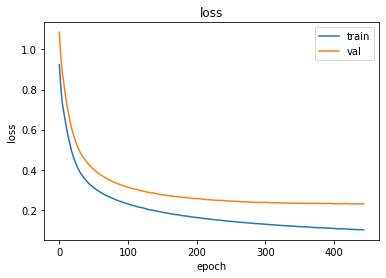

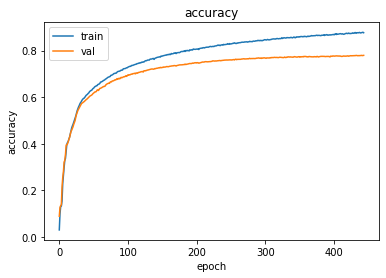

In [27]:
# Training

training_info = {
    'verbose': 1,
    'epochs': 1000,
    'batch_size': 32,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=15,
                                                restore_best_weights=True)]
}
GRU_model = train_model(model=GRU_model, x_train=x_train, y_train=y_train,
                    x_val=x_val, y_val=y_val, training_info=training_info)

##Additional LSTM

###Compile

In [28]:
two_LSTM = Sequential()

# Embedding layer
two_LSTM.add(Embedding(input_dim = vocab_size,
              input_length = max_seq_length,
              output_dim=embedding_dimension,
              weights = embedding_matrix if embedding_matrix is None else [embedding_matrix],
              trainable=False,
              mask_zero=True))

# Bidirectional layers
two_LSTM.add(Bidirectional(LSTM(64, return_sequences=True 
               ,dropout=0.1
               )))         
two_LSTM.add(Bidirectional(LSTM(32, return_sequences=True 
               ,dropout=0.1
               )))              

# Dense layer

two_LSTM.add(TimeDistributed(Dense(num_classes,
            activation= 'softmax')))

# Compile the model
two_LSTM.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
two_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1897, 200)         2189800   
                                                                 
 bidirectional_2 (Bidirectio  (None, 1897, 128)        135680    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 1897, 64)         41216     
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 1897, 46)         2990      
 tributed)                                                       
                                                                 
Total params: 2,369,686
Trainable params: 179,886
Non-trainable params: 2,189,800
______________________________________

###Train

Start training! 
Parameters: {'verbose': 1, 'epochs': 1000, 'batch_size': 32, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x000001DCECC0B820>]}
Train size: 100
Val size: 50
Epoch 1/1000
4/4 [==============================] - 16s 2s/step - loss: 0.9138 - accuracy: 0.0532 - val_loss: 1.0685 - val_accuracy: 0.0854
Epoch 2/1000
4/4 [==============================] - 2s 530ms/step - loss: 0.8510 - accuracy: 0.1087 - val_loss: 1.0145 - val_accuracy: 0.1106
Epoch 3/1000
4/4 [==============================] - 2s 488ms/step - loss: 0.8119 - accuracy: 0.1095 - val_loss: 0.9798 - val_accuracy: 0.1074
Epoch 4/1000
4/4 [==============================] - 2s 470ms/step - loss: 0.7856 - accuracy: 0.1082 - val_loss: 0.9538 - val_accuracy: 0.1178
Epoch 5/1000
4/4 [==============================] - 2s 439ms/step - loss: 0.7662 - accuracy: 0.1396 - val_loss: 0.9346 - val_accuracy: 0.1637
Epoch 6/1000
4/4 [==============================] - 2s 547ms/step - loss: 0.7521 - accuracy: 0.1410 - val_lo

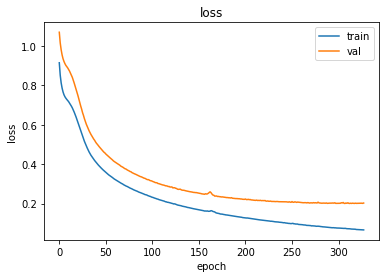

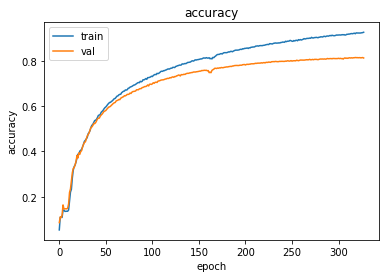

In [29]:
# Training

training_info = {
    'verbose': 1,
    'epochs': 1000,
    'batch_size': 32,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=15,
                                                restore_best_weights=True)]
}
two_LSTM = train_model(model=two_LSTM, x_train=x_train, y_train=y_train,
                    x_val=x_val, y_val=y_val, training_info=training_info)


##Additional Dense Layer

###Compile

In [30]:
two_dense = Sequential()

# Embedding layer
two_dense.add(Embedding(input_dim = vocab_size,
              input_length = max_seq_length,
              output_dim=embedding_dimension,
              weights = embedding_matrix if embedding_matrix is None else [embedding_matrix],
              trainable=False,
              mask_zero=True))

# Bidirectional layer
two_dense.add(Bidirectional(LSTM(32, return_sequences=True 
               ,dropout=0.1
               )))             

# Dense layer
two_dense.add(TimeDistributed(Dense(128,
            activation= 'relu')))

# Output
two_dense.add(TimeDistributed(Dense(num_classes,
            activation= 'softmax')))

# Compile the model
two_dense.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
two_dense.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1897, 200)         2189800   
                                                                 
 bidirectional_4 (Bidirectio  (None, 1897, 64)         59648     
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 1897, 128)        8320      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 1897, 46)         5934      
 tributed)                                                       
                                                                 
Total params: 2,263,702
Trainable params: 73,902
Non-trainable params: 2,189,800
_______________________________________

###Train

Start training! 
Parameters: {'verbose': 1, 'epochs': 1000, 'batch_size': 32, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x000001DD2C624C10>]}
Train size: 100
Val size: 50
Epoch 1/1000
4/4 [==============================] - 8s 912ms/step - loss: 0.9293 - accuracy: 0.0336 - val_loss: 1.1153 - val_accuracy: 0.0563
Epoch 2/1000
4/4 [==============================] - 1s 224ms/step - loss: 0.8948 - accuracy: 0.0629 - val_loss: 1.0705 - val_accuracy: 0.0646
Epoch 3/1000
4/4 [==============================] - 1s 257ms/step - loss: 0.8554 - accuracy: 0.0668 - val_loss: 1.0171 - val_accuracy: 0.0667
Epoch 4/1000
4/4 [==============================] - 1s 235ms/step - loss: 0.8089 - accuracy: 0.0764 - val_loss: 0.9630 - val_accuracy: 0.1125
Epoch 5/1000
4/4 [==============================] - 1s 213ms/step - loss: 0.7677 - accuracy: 0.1439 - val_loss: 0.9201 - val_accuracy: 0.1254
Epoch 6/1000
4/4 [==============================] - 1s 225ms/step - loss: 0.7332 - accuracy: 0.1505 - val_

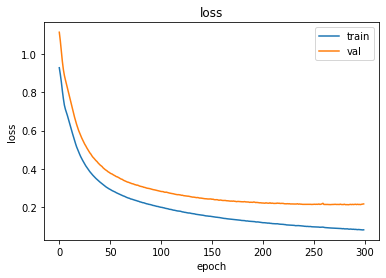

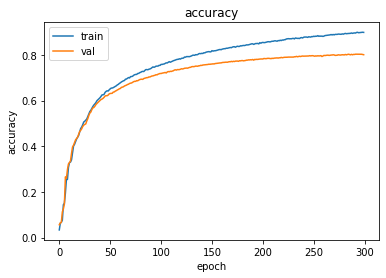

In [31]:
# Training

training_info = {
    'verbose': 1,
    'epochs': 1000,
    'batch_size': 32,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=15,
                                                restore_best_weights=True)]
}
two_dense = train_model(model=two_dense, x_train=x_train, y_train=y_train,
                    x_val=x_val, y_val=y_val, training_info=training_info)


##Inference

In [ ]:
# sometimes colab assigns the name zip to a variable leading to errors when zip() is called
del zip

###Baseline model Evaluation

In [33]:
# predict

prediction_info = {
    'batch_size': 32,
    'verbose': 1
}
test_predictions_base = predict_data(model=baseline, x=x_test,
                                      prediction_info=prediction_info)

# Retrieving labels from raw predictions
test_predictions_base = np.argmax(test_predictions_base, axis=-1)

Starting prediction: 
{'batch_size': 32, 'verbose': 1}
Predicting on 49 samples
2/2 [==============================] - 2s 129ms/step


For the evaluations, we remove the padding from the predictions and the y_test so they do not affect the scores. We then flatten them since our model input was documents (multiple arrays) instead of one single array.

In [34]:
# remove padding from labels
i=0
test_predictions_base = list(test_predictions_base)
y_test = list(y_test)

for i in range(len(y_test)):
    test_predictions_base[i]= test_predictions_base[i][ : y_test_lens[i]]
    y_test[i]= y_test[i][ : y_test_lens[i]]

In [35]:
# flatten predictions to apply the metrics on all words
flat_preds_base = [item for sublist in test_predictions_base for item in sublist]
flat_y_base = [item for sublist in y_test for item in sublist]

# save tags of test set only
test_tags_base = set(flat_y_base)

In [36]:
# get list of tags without punctuation
eval_tag_ids_base = copy.copy(tag_ids)
eval_tags_base = copy.copy(tags)
i=len(eval_tag_ids_base)-1
while i > 0:
    if eval_tag_ids_base[i] in [7,8,23,24,25,26,40] or eval_tag_ids_base[i] not in test_tags_base:
        del eval_tag_ids_base[i]
        del eval_tags_base[i]
    i-=1

In [37]:
sample_base_f1=f1_score(flat_y_base,flat_preds_base,labels=eval_tag_ids_base,average='macro')
print('macro F1-score of Baseline: {:.2f}'.format(sample_base_f1))
acc_base = accuracy_score(flat_y_base,flat_preds_base)
print('Accuracy of Baseline: {:.2f}'.format(acc_base))

macro F1-score of Baseline: 0.73
Accuracy of Baseline: 0.81


In [38]:
# class-specific F1 scores

sample_base_f1=f1_score(flat_y_base,flat_preds_base,labels=eval_tag_ids_base,average=None,zero_division=0)

print('tag_id\ttag\tf1\n--------------------------------')
for i,el in enumerate(sample_base_f1):
    print('{}\t{}\t{:.2f}'.format(i+1,eval_tags_base[i],el))

tag_id	tag	f1
--------------------------------
1	nn	0.72
2	in	0.95
3	nnp	0.63
4	dt	0.99
5	nns	0.62
6	jj	0.57
7	cd	0.82
8	vbd	0.80
9	rb	0.64
10	vb	0.84
11	cc	0.99
12	to	1.00
13	vbn	0.63
14	vbz	0.80
15	prp	0.98
16	vbg	0.49
17	vbp	0.72
18	md	0.98
19	pos	0.99
20	prp$	0.99
21	wdt	0.88
22	jjr	0.67
23	nnps	0.00
24	wp	0.98
25	rp	0.71
26	jjs	0.68
27	wrb	0.96
28	rbr	0.28
29	-rrb-	0.97
30	-lrb-	0.94
31	ex	0.91
32	rbs	0.00
33	pdt	0.00
34	wp$	0.67


In [109]:
# display some results of baseline model
preds_base = copy.deepcopy(test_predictions_base)
converted_base=tags_tokenizer.convert_ids_to_tokens(preds_base)
for tag in converted_base[0].split(' '):
    print(tag.upper())

NNP
NNP
NNP
,
NNP
NNP
,
NNP
,
VBD
PRP
VBD
NN
CD
NNS
,
CC
RB
CD
NN
,
IN
PRP$
JJ
NN
IN
DT
VBG
NN
IN
$
CD
DT
NN
,
CC
$
CD
CD
.
DT
NN
VBD
NNP
NN
NNP
NNP
POS
CD
TO
CD
NN
IN
CD
NN
CC
MD
VB
VB
JJ
NNS
IN
VBG
DT
NN
IN
DT
NN
NN
.
NNP
NNP
RB
VBZ
VBG
TO
VB
NNP
NNP
IN
NN
IN
NNP
NNP
,
DT
JJ
NN
.
DT
NN
NN
IN
CD
NN
DT
NN
VBN
IN
PRP
MD
VB
DT
NN
NN
TO
VB
NNS
``
TO
VB
JJ
NN
,
''
VBG
DT
JJ
NN
IN
DT
NN
.
IN
NNP
NNP
NNP
NNP
JJ
NN
NN
,
JJ
NNS
VBD
JJ
NNS
TO
VB
IN
$
CD
.
NNP
VBD
VBD
TO
VB
WP
VBD
DT
JJ
NNS
,
VBG
PRP
VBP
VBG
RB
TO
NNP
NNS
WRB
``
DT
NN
VBZ
IN
DT
NN
.
''
PRP
VBD
,
``
DT
VBZ
VBN
TO
VB
IN
JJ
NNS
CC
PRP
VBZ
RB
NN
,
RB
,
TO
VB
DT
NN
NN
.
''
CC
NNP
NNP
VBD
DT
NN
,
CC
DT
NN
NN
VBN
,
NN
IN
NNP
NNP
VBZ
VBG
NNS
.


###2 LSTM model Evaluation

In [40]:
# predict

prediction_info = {
    'batch_size': 32,
    'verbose': 1
}
test_predictions_2LSTM = predict_data(model=two_LSTM, x=x_test,
                                      prediction_info=prediction_info)

# Retrieving labels from raw predictions
test_predictions_2LSTM = np.argmax(test_predictions_2LSTM, axis=-1)

Starting prediction: 
{'batch_size': 32, 'verbose': 1}
Predicting on 49 samples
2/2 [==============================] - 4s 153ms/step


In [41]:
# remove padding from labels
i=0
test_predictions_2LSTM = list(test_predictions_2LSTM)
y_test = list(y_test)

for i in range(len(y_test)):
    test_predictions_2LSTM[i]= test_predictions_2LSTM[i][ : y_test_lens[i]]
    y_test[i]= y_test[i][ : y_test_lens[i]]

In [42]:
# flatten predictions to apply metrics on all predictions
flat_preds_2LSTM = [item for sublist in test_predictions_2LSTM for item in sublist]
flat_y_2LSTM = [item for sublist in y_test for item in sublist]

# save tags of test set only
test_tags_2LSTM = set(flat_y_2LSTM)

In [43]:
# get list of tags without punctuation
eval_tag_ids_2LSTM = copy.copy(tag_ids)
eval_tags_2LSTM = copy.copy(tags)
i=len(eval_tag_ids_2LSTM)-1
while i > 0:
    if eval_tag_ids_2LSTM[i] in [7,8,23,24,25,26,40] or eval_tag_ids_2LSTM[i] not in test_tags_2LSTM:
        del eval_tag_ids_2LSTM[i]
        del eval_tags_2LSTM[i]
    i-=1

In [44]:
sample_2LSTM_f1=f1_score(flat_y_2LSTM,flat_preds_2LSTM,labels=eval_tag_ids_2LSTM,average='macro')
print('macro F1-score of 2 LSTM: {:.2f}'.format(sample_2LSTM_f1))
acc_2LSTM = accuracy_score(flat_y_2LSTM,flat_preds_2LSTM)
print('Accuracy of 2 LSTM: {:.2f}'.format(acc_2LSTM))

macro F1-score of 2 LSTM: 0.69
Accuracy of 2 LSTM: 0.83


In [85]:
# class-specific F1 scores

sample_2LSTM_f1=f1_score(flat_y_2LSTM,flat_preds_2LSTM,labels=eval_tag_ids_2LSTM,average=None,zero_division=0)

tuples = []
print('tag_id\ttag\tf1\n--------------------------------')
for i,el in enumerate(sample_2LSTM_f1):
    tuples.append((eval_tags_2LSTM[i],np.round(el,2)))
    print('{}\t{}\t{:.2f}'.format(i+1,eval_tags_2LSTM[i],el))

tag_id	tag	f1
--------------------------------
1	nn	0.76
2	in	0.97
3	nnp	0.70
4	dt	0.99
5	nns	0.65
6	jj	0.62
7	cd	0.85
8	vbd	0.81
9	rb	0.66
10	vb	0.85
11	cc	0.99
12	to	1.00
13	vbn	0.64
14	vbz	0.81
15	prp	0.97
16	vbg	0.47
17	vbp	0.75
18	md	0.98
19	pos	0.99
20	prp$	1.00
21	wdt	0.88
22	jjr	0.59
23	nnps	0.00
24	wp	0.98
25	rp	0.56
26	jjs	0.18
27	wrb	0.91
28	rbr	0.19
29	-rrb-	0.91
30	-lrb-	0.94
31	ex	0.91
32	rbs	0.00
33	pdt	0.00
34	wp$	0.00


In [107]:
# display some results of 2 LSTM model
preds_2LSTM = copy.deepcopy(test_predictions_2LSTM)
converted_2LSTM=tags_tokenizer.convert_ids_to_tokens(preds_2LSTM)
for tag in converted_2LSTM[0].split(' '):
    print(tag.upper())

NNP
NNP
NNP
,
NNP
NNP
,
NNP
,
VBD
PRP
VBD
CD
CD
NNS
,
CC
RB
CD
NN
,
IN
PRP$
JJ
NN
IN
DT
JJ
NN
IN
$
CD
DT
NN
,
CC
$
CD
CD
.
DT
NN
VBD
RB
NN
NNP
NNP
POS
NN
TO
CD
NN
IN
CD
NN
CC
MD
VB
VBN
CD
NNS
IN
VBG
DT
NN
IN
DT
NN
NN
.
NNP
NNP
RB
VBZ
VBG
TO
VB
NNP
NNP
IN
NN
IN
NNP
NNP
,
DT
JJ
NN
.
DT
NN
VBN
IN
CD
NN
DT
NN
NN
IN
PRP
MD
VB
DT
NN
NN
TO
VB
VB
``
TO
VB
NN
NN
,
''
VBG
DT
JJ
NN
IN
DT
NN
.
IN
NNP
NNP
NNP
NNP
JJ
NN
NN
,
NNP
NNS
VBD
VBN
NNS
TO
VB
IN
$
CD
.
NNP
NNP
VBD
TO
VB
WP
VBD
DT
JJ
NN
,
VBG
PRP
VBP
VBG
RB
TO
VB
NNS
WRB
``
DT
NN
VBZ
IN
DT
NN
.
''
PRP
VBD
,
``
DT
VBZ
VBN
TO
VB
IN
JJ
NNS
CC
PRP
VBZ
RB
JJ
,
RB
,
TO
VB
DT
NN
JJ
.
''
CC
NNP
NNP
VBD
DT
NN
,
CC
DT
JJ
NN
NN
,
NN
IN
NNP
NNP
VBZ
JJ
NN
.


###2 Dense model Evaluation

In [47]:
# predict

prediction_info = {
    'batch_size': 32,
    'verbose': 1
}
test_predictions_2Dense = predict_data(model=two_dense, x=x_test,
                                      prediction_info=prediction_info)

# Retrieving labels from raw predictions
test_predictions_2Dense = np.argmax(test_predictions_2Dense, axis=-1)

Starting prediction: 
{'batch_size': 32, 'verbose': 1}
Predicting on 49 samples
2/2 [==============================] - 2s 107ms/step


In [48]:
# remove padding from labels
i=0
test_predictions_2Dense = list(test_predictions_2Dense)
y_test = list(y_test)

for i in range(len(y_test)):
    test_predictions_2Dense[i]= test_predictions_2Dense[i][ : y_test_lens[i]]
    y_test[i]= y_test[i][ : y_test_lens[i]]

In [49]:
# flatten predictions to apply metrics on all predictions
flat_preds_2Dense = [item for sublist in test_predictions_2Dense for item in sublist]
flat_y_2Dense = [item for sublist in y_test for item in sublist]

# save tags of test set only
test_tags_2Dense = set(flat_y_2Dense)

In [50]:
# get list of tags without punctuation
eval_tag_ids_2Dense = copy.copy(tag_ids)
eval_tags_2Dense = copy.copy(tags)
i=len(eval_tag_ids_2Dense)-1
while i > 0:
    if eval_tag_ids_2Dense[i] in [7,8,23,24,25,26,40] or eval_tag_ids_2Dense[i] not in test_tags_2Dense:
        del eval_tag_ids_2Dense[i]
        del eval_tags_2Dense[i]
    i-=1

In [51]:
sample_2Dense_f1=f1_score(flat_y_2Dense,flat_preds_2Dense,labels=eval_tag_ids_2Dense,average='macro')
print('macro F1-score of 2 Dense:{:.2f}'.format(sample_2Dense_f1))
acc_2Dense = accuracy_score(flat_y_2Dense,flat_preds_2Dense)
print('Accuracy of 2 Dense: {:.2f}'.format(acc_2Dense))

macro F1-score of 2 Dense:0.71
Accuracy of 2 Dense: 0.81


In [52]:
# class-specific F1 scores

sample_2Dense_f1=f1_score(flat_y_2Dense,flat_preds_2Dense,labels=eval_tag_ids_2Dense,average=None,zero_division=0)

print('tag_id\ttag\tf1\n--------------------------------')
for i,el in enumerate(sample_2Dense_f1):
    print('{}\t{}\t{:.2f}'.format(i+1,eval_tags_2Dense[i],el))

tag_id	tag	f1
--------------------------------
1	nn	0.73
2	in	0.97
3	nnp	0.65
4	dt	0.99
5	nns	0.63
6	jj	0.62
7	cd	0.82
8	vbd	0.80
9	rb	0.65
10	vb	0.82
11	cc	0.99
12	to	1.00
13	vbn	0.63
14	vbz	0.81
15	prp	0.98
16	vbg	0.48
17	vbp	0.73
18	md	0.98
19	pos	0.99
20	prp$	0.99
21	wdt	0.89
22	jjr	0.67
23	nnps	0.00
24	wp	1.00
25	rp	0.58
26	jjs	0.48
27	wrb	0.93
28	rbr	0.25
29	-rrb-	1.00
30	-lrb-	1.00
31	ex	0.91
32	rbs	0.00
33	pdt	0.00
34	wp$	0.00


In [108]:
# display some results of 2 Dense model
preds_2Dense = copy.deepcopy(test_predictions_2Dense)
converted_2Dense=tags_tokenizer.convert_ids_to_tokens(preds_2Dense)
for tag in converted_2Dense[0].split(' '):
    print(tag.upper())

NNP
NNP
NNP
,
NNP
NNP
,
NNP
,
VBD
PRP
VBD
CD
CD
NNS
,
CC
IN
CD
NN
,
IN
PRP$
JJ
NN
IN
DT
JJ
NN
IN
$
CD
DT
NN
,
CC
$
CD
CD
.
DT
NN
NN
NNP
NNP
NNP
NNP
POS
NNP
TO
CD
NN
IN
CD
NN
CC
MD
VB
JJ
NNP
NNS
IN
VBG
DT
NN
IN
DT
NN
NN
.
NNP
NNP
RB
VBZ
VBG
TO
VB
NNP
NNP
IN
NN
IN
NNP
NNP
,
DT
JJ
NN
.
DT
NN
VBD
IN
CD
NN
DT
JJ
NN
IN
PRP
MD
VB
DT
NN
NN
TO
NNP
RB
``
TO
VB
RB
NN
,
''
VBG
DT
NN
NN
IN
DT
NN
.
IN
NNP
NNP
NNP
NNP
JJ
NN
NN
,
JJ
NNS
VBD
JJ
NNS
TO
VB
IN
$
CD
.
NNP
NNP
VBD
TO
VB
WP
NNS
DT
JJ
NN
,
VBG
PRP
VBP
VBN
RB
TO
CD
NNS
WRB
``
DT
NN
VBZ
IN
DT
NN
.
''
PRP
VBD
,
``
DT
VBZ
VBN
TO
VB
IN
JJ
NNS
CC
PRP
VBZ
RB
VBN
,
RB
,
TO
VB
DT
NN
JJ
.
''
CC
NNP
NNP
VBD
DT
NN
,
CC
DT
JJ
NN
VBN
,
NN
IN
NNP
NNP
VBZ
RB
VBN
.


#3- Data visualization and Error Analysis

If we plot the frequency of each class, we notice that there is a **huge class imbalance** which is inherent to language (for example, determinants -DT- are more frequent than plural proper nouns -NNPS-). This can negatively affect the learning process of the model since it is not provided the same quantity of each class to learn from. This, along with the proper difficulty of a specific class decide how difficult it is to learn. This might explain the discrepancy between the test accuracy score and F1 scores.  

<BarContainer object of 45 artists>

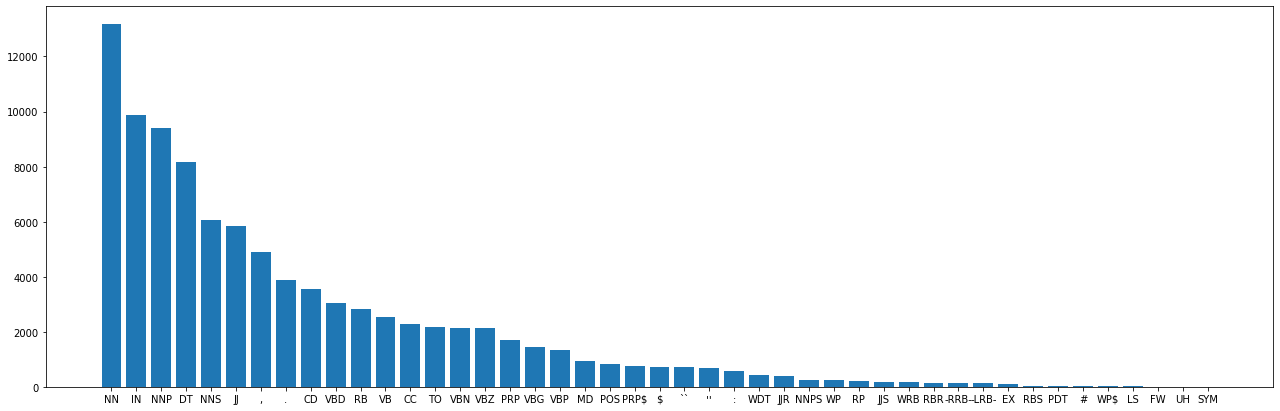

In [105]:
from collections import Counter

# plot frequency of each class for the whole dataset
data = df['tags'].values
all_tags = []
for l in data:
    for e in l:
        all_tags.append(e)
freqs = Counter(all_tags).most_common()
x=[]
y=[]
for (tag,freq) in freqs:
    x.append(tag)
    y.append(freq)

plt.rcParams['figure.figsize'] = (22,7)
plt.bar(x,y)

(49,)


<BarContainer object of 40 artists>

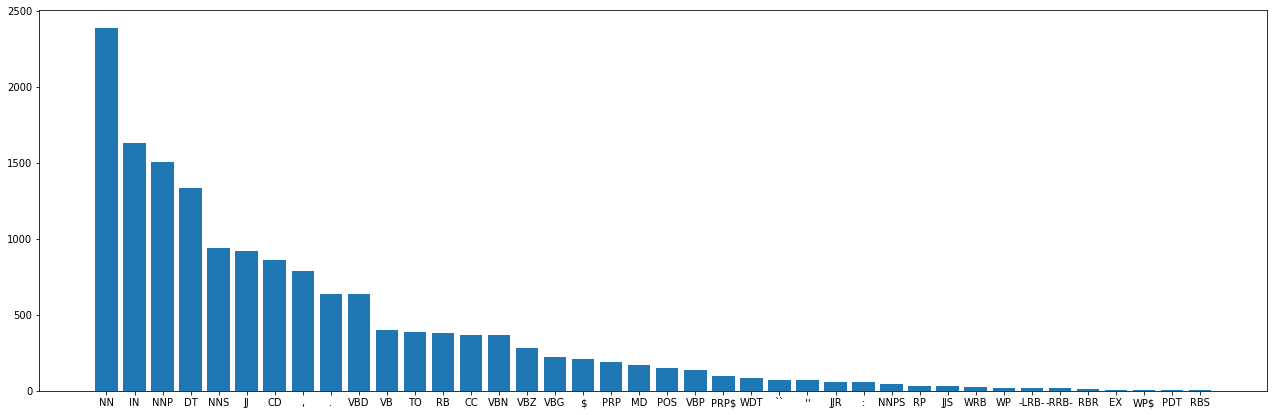

In [106]:
from collections import Counter

# plot frequency of each class for the training split
data = df[df['split'] == 'test']
data = data['tags'].values

print(data.shape)

all_tags = []
for l in data:
    for e in l:
        all_tags.append(e)
freqs = Counter(all_tags).most_common()
x=[]
y=[]
for (tag,freq) in freqs:
    x.append(tag)
    y.append(freq)

plt.rcParams['figure.figsize'] = (22,7)
plt.bar(x,y)

In [95]:
# print sorted class-specific F1 scores 
sorted_scores = sorted(tuples, key=lambda x: x[1],reverse=True)
print('tag\tscore\n-------------')
for tag, score in sorted_scores:
    print('{}\t{}'.format(tag,score))

tag	score
-------------
to	1.0
prp$	1.0
dt	0.99
cc	0.99
pos	0.99
md	0.98
wp	0.98
in	0.97
prp	0.97
-lrb-	0.94
wrb	0.91
-rrb-	0.91
ex	0.91
wdt	0.88
cd	0.85
vb	0.85
vbd	0.81
vbz	0.81
nn	0.76
vbp	0.75
nnp	0.7
rb	0.66
nns	0.65
vbn	0.64
jj	0.62
jjr	0.59
rp	0.56
vbg	0.47
rbr	0.19
jjs	0.18
nnps	0.0
rbs	0.0
pdt	0.0
wp$	0.0
